In [1]:
# ~~~~~~~~~~~~~~~~
# PyTorch Model

import torch
import yaml
from models.decoder import architectures

with open("models/decoder/decoder_params.yaml") as file:
    params = yaml.safe_load(file)

decoder = architectures.LightningDecoderNet.load_from_checkpoint("logs/bestparams/version_0/checkpoints/epoch=49-step=75900.ckpt")
decoder.eval();

decoder_denoise = architectures.LightningDecoderNet.load_from_checkpoint("logs/bestparams_noise/version_1/checkpoints/epoch=49-step=75900.ckpt")
decoder_denoise.eval();

# ~~~~~~~~~~~~~~~~
# Kernel DM+V

from models.kernel_dmv.my_kernel_dmv import KernelDMV
kdm = KernelDMV()

# ~~~~~~~~~~~~~~~~
# GMRF

from models.gmrf.my_gmrf import myGMRF
gmrf = myGMRF()

In [11]:
from torch.utils import data
from data.gdm_realdataset import RealGasDataSet

dataset = RealGasDataSet("data/6x5_realData/02apr.pt")
#loader = data.DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True)
#data_iter = iter(loader)

### Paper Visualization

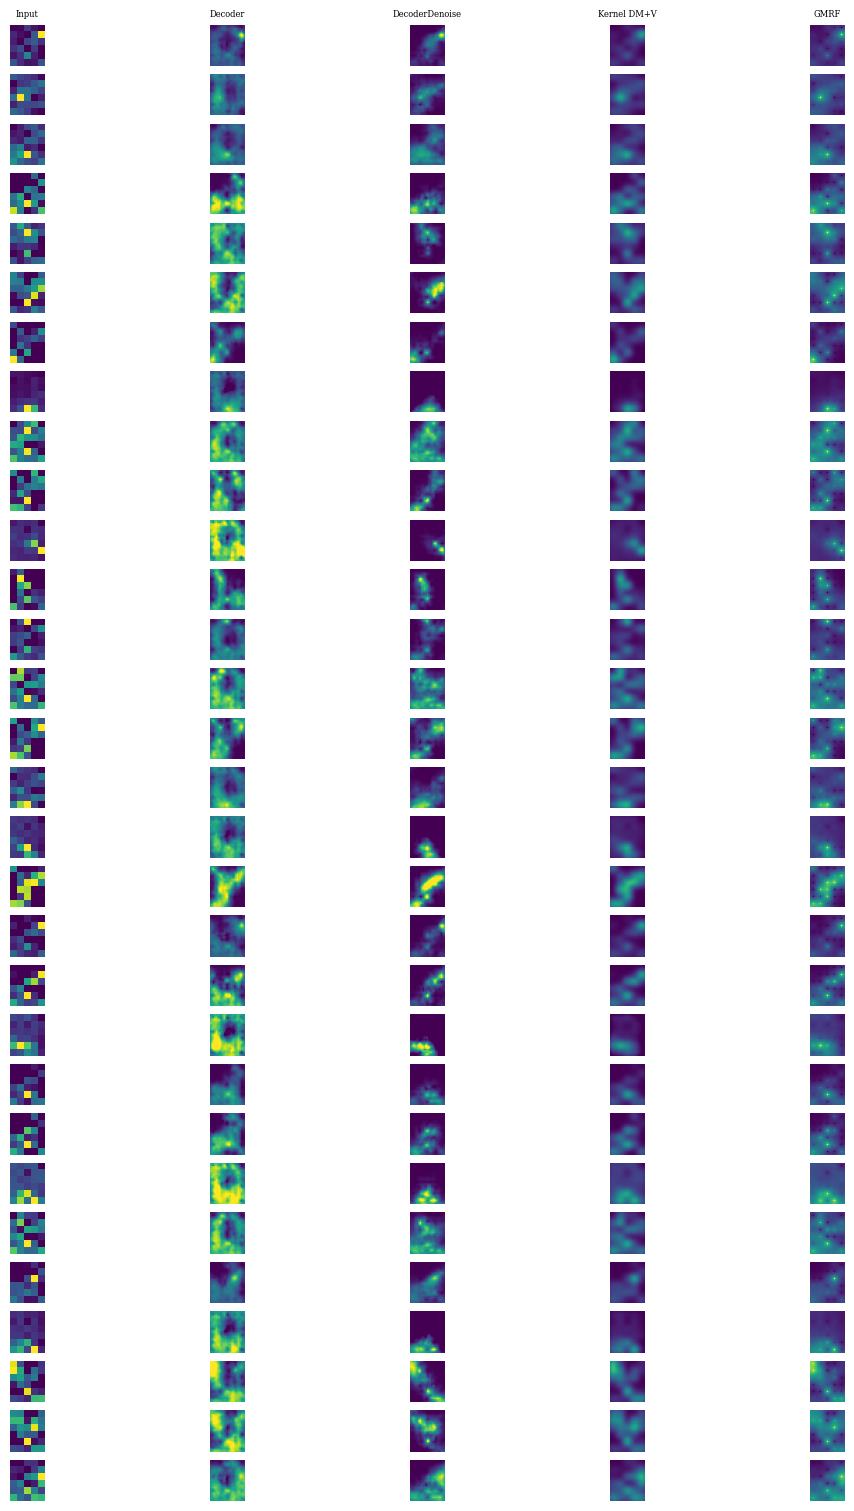

In [12]:
from utils import plot_dict, draw_random_samples

def draw_random_samples(n_samples, dataset, sequential=False):
    """ Take a dataset and draw n random samples from the dataset. 
    
    Input:    
    n_samples: The amount of samples
    dataset: torch.data.Dataset
    sequential: True, if the sequence length dimension should be removed
    
    Output:
    X_list: A list containing n tensors with input data for model
    """
    
    loader = data.DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True)
    data_iter = iter(loader) 
    
    X_list = []
    
    for i in range(n_samples):
        X = next(data_iter)
        X = X.squeeze(1) # remove the sequence length dimension
        X_list.append(X)
    
    return X_list

X_list = draw_random_samples(30, dataset)

indices = list(range(30))
X_l = [X_list[i] for i in indices]
#y_l = [y_list[i] for i in indices]

data = {
        "Input": X_l,
        #"Truth": y_l,
        "Decoder": [decoder(x.squeeze(1)) for x in X_l],
        "DecoderDenoise": [decoder_denoise(x.squeeze(1)) for x in X_l],
        "Kernel DM+V": [kdm.calculate(x.squeeze()) for x in X_l],
        "GMRF": [gmrf.calculate(x.squeeze()) for x in X_l],
        }

fig, axes = plot_dict(data, [10,15]);

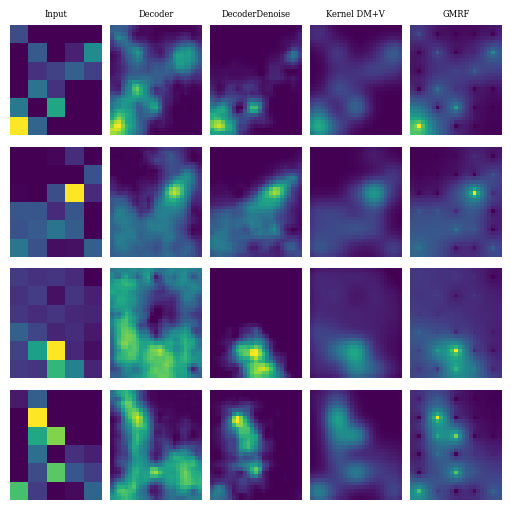

In [19]:
import matplotlib as mpl

indices = [6,25,16,11]
X_l = [X_list[i] for i in indices]
#y_l = [y_list[i] for i in indices]

data = {
        "Input": X_l,
        #"Truth": y_l,
        "Decoder": [decoder(x.squeeze(1)) for x in X_l],
        "DecoderDenoise": [decoder_denoise(x.squeeze(1)) for x in X_l],
        "Kernel DM+V": [kdm.calculate(x.squeeze()) for x in X_l],
        "GMRF": [gmrf.calculate(x.squeeze()) for x in X_l],
        }

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : '5',
    #'text.usetex': True,
    'pgf.rcfonts': False,
})

fig, axes = plot_dict(data, [5,5]);
mpl.pyplot.savefig("pgf/real_data/real_data.pgf", bbox_inches='tight', facecolor="w", pad_inches=0, dpi=500)

## Leave-One-Out 

In [14]:
import scipy.interpolate as interpolate
import numpy as np

def find_pos(pos):
    n = 5
    i = 0
    pos_mat = torch.zeros([30,25])
    for row in range(int(n/2), pos_mat.shape[0], n): 
        for col in range(int(n/2), pos_mat.shape[1], n):
            if i == pos:
                pos_mat[row,col] = 1
            i+=1
            
    pos_large = torch.tensor(range(30*25))*pos_mat.flatten()
    return pos_large.nonzero().squeeze().numpy()

def drop_position(X, pos_dropped):
    """Interpolate a batch of size [batch, channel, width, height]"""
    device = X.device
    all_interpolated = torch.empty([1,6,5], device=device)
    
    for sample in range(X.shape[0]):
        this_X = X[sample][0].clone()
        
        r = np.linspace(0, 1, this_X.squeeze().shape[0])
        c = np.linspace(0, 1, this_X.squeeze().shape[1])

        rr, cc = np.meshgrid(c, r)
        mask = torch.ones([6,5], device=device).flatten().bool()
        mask[pos_dropped] = 0
        mask = mask.reshape([6,5])
        try:
            f = interpolate.Rbf(rr[mask.cpu().numpy()], cc[mask.cpu().numpy()], this_X.squeeze()[mask].cpu().numpy(), function='linear')
            interpolated = torch.tensor(f(rr, cc), device=device).unsqueeze(0).float()
        except:
            print("Except! No interpolation possible. Leave sample as it is (No dropout).")
            interpolated = this_X   

        all_interpolated = torch.cat([all_interpolated, interpolated])
        
    all_interpolated = all_interpolated.unsqueeze(1)
    return all_interpolated[1:]

## 02apr

In [3]:
import matplotlib.pyplot as plt

In [10]:
list_of_models = [
                  "decoder",
                  "decoder_denoise"
                  #"gmrf",
                  #"kdm",
                 ]

In [19]:
import random
from torch.nn import functional as F
from tqdm import tqdm


mae = {"decoder": 0, "decoder_denoise": 0, "gmrf": 0, "kdm": 0}
mse = {"decoder": 0, "decoder_denoise": 0, "gmrf": 0, "kdm": 0}

dataset = RealGasDataSet("data/6x5_realData/02apr_log.pt")
dataloader = iter(data.DataLoader(dataset, shuffle=False, drop_last=True))

for X in tqdm(dataloader):
    pos_dropped = random.randint(0,29)
    true_val = X.flatten()[pos_dropped]
    
    X_interp = drop_position(X, pos_dropped)
    X_interp = X_interp.to(decoder.device)
    X_interp = torch.clamp(X_interp, min=0)
        
    # Find position in large img
    pos = find_pos(pos_dropped)
    
    with torch.no_grad(): 
        if "decoder" in list_of_models:
            y_decoder = decoder(X_interp.squeeze(1))
            mae["decoder"] += F.l1_loss(y_decoder.flatten()[pos], true_val)
            #mse["decoder"] += torch.sqrt(F.mse_loss(y_decoder.flatten()[pos], true_val))

        if "decoder_denoise" in list_of_models:
            y_decoder = decoder_denoise(X_interp.squeeze(1))
            mae["decoder_denoise"] += F.l1_loss(y_decoder.flatten()[pos], true_val)
            #mse["decoder_denoise"] += torch.sqrt(F.mse_loss(y_decoder.flatten()[pos], true_val))
            
print(f"########\n# MAE #\n########")
for elem in mae:
    print(f"{elem}: \t {mae[elem]/len(dataset)}")
    
print(f"########\n# MSE #\n########")
for elem in mse:
    print(f"{elem}: \t {mse[elem]/len(dataset)}")

100%|██████████| 114000/114000 [11:15<00:00, 168.79it/s]

########
# MAE #
########
decoder: 	 0.10760432481765747
decoder_denoise: 	 0.08787522464990616
gmrf: 	 0.0
kdm: 	 0.0
########
# MSE #
########
decoder: 	 0.0
decoder_denoise: 	 0.0
gmrf: 	 0.0
kdm: 	 0.0


### Log scaled

In [12]:
import random
from torch.nn import functional as F
from tqdm import tqdm


mae = {"decoder": 0,
        "gmrf": 0,
        "kdm": 0}

mse = {"decoder": 0,
        "gmrf": 0,
        "kdm": 0}

dataset = RealGasDataSet("data/6x5_realData/02apr_log.pt")
dataloader = iter(data.DataLoader(dataset, shuffle=False, drop_last=True))

for X in tqdm(dataloader):
    pos_dropped = random.randint(0,29)
    true_val = X.flatten()[pos_dropped]
        
    #X_drop = interpolate_batch(X, dropout_probability)
    #X_drop = torch.clamp(X_drop, min=0)
    X_interp = drop_position(X, pos_dropped)
    X_interp = torch.clamp(X_interp, min=0)
    
    # Find position in large img
    pos = find_pos(pos_dropped)
    
    with torch.no_grad(): 
        if "decoder" in list_of_models:
            y_decoder = decoder_denoise(X_interp.squeeze(1))
            mae["decoder"] += F.l1_loss(y_decoder.flatten()[pos], true_val)
            mse["decoder"] += torch.sqrt(F.mse_loss(y_decoder.flatten()[pos], true_val))

        if "gmrf" in list_of_models:
            y_gmrf = gmrf.calculate(X_interp.squeeze())[None,None,:]  # add two empty dimensions to be consistent with y.shape
            mae["gmrf"] += F.l1_loss(y_gmrf.flatten()[pos], true_val)
            mse["gmrf"] += torch.sqrt(F.mse_loss(y_gmrf.flatten()[pos], true_val))

        if "kdm" in list_of_models:
            y_kdm = kdm.calculate(X_interp.squeeze())[None,None,:]    # add two empty dimensions to be consistent with y.shape
            mae["kdm"] += F.l1_loss(y_kdm.flatten()[pos], true_val)
            mse["kdm"] += torch.sqrt(F.mse_loss(y_kdm.flatten()[pos], true_val))
            
print(f"########\n# MAE #\n########")
for elem in mae:
    print(f"{elem}: \t {mae[elem]/len(dataset)}")
    
print(f"########\n# MSE #\n########")
for elem in mse:
    print(f"{elem}: \t {mse[elem]/len(dataset)}")

100%|█████████████████████████████████| 114000/114000 [5:33:13<00:00,  5.70it/s]

########
# MAE #
########
decoder: 	 0.09146200120449066
gmrf: 	 0.07877910358076227
kdm: 	 0.07156770866807284
########
# MSE #
########
decoder: 	 0.09146200120449066
gmrf: 	 0.07877910358076227
kdm: 	 0.07156770866807284


## 03jul

In [20]:
import random
from torch.nn import functional as F
from tqdm import tqdm

list_of_models = [
                  "decoder",
                  "decoder_denoise",
                #   "gmrf",
                #   "kdm",
                 ]

mae = {"decoder": 0,
       "decoder_denoise":0,
        "gmrf": 0,
        "kdm": 0}

mse = {"decoder": 0,
       "decoder_denoise":0,
        "gmrf": 0,
        "kdm": 0}

dataset = RealGasDataSet("data/6x5_realData/03jul_log.pt")
dataloader = iter(data.DataLoader(dataset, shuffle=False, drop_last=True))

i = 0
 
for X in tqdm(dataloader):
    pos_dropped = random.randint(0,29)
    true_val = X.flatten()[pos_dropped]
    
    # Find position in large img
    pos = find_pos(pos_dropped)
    
    #X_drop = interpolate_batch(X, dropout_probability)
    #X_drop = torch.clamp(X_drop, min=0)
    X_interp = drop_position(X, pos_dropped)
    X_interp = torch.clamp(X_interp, min=0)
    X_interp = X_interp.to(decoder.device)
    
    with torch.no_grad(): 
        #try:
            if "gmrf" in list_of_models:
                y_gmrf = gmrf.calculate(X_interp.squeeze())[None,None,:]  # add two empty dimensions to be consistent with y.shape
                mae["gmrf"] += F.l1_loss(y_gmrf.flatten()[pos], true_val)
                mse["gmrf"] += torch.sqrt(F.mse_loss(y_gmrf.flatten()[pos], true_val))

            if "kdm" in list_of_models:
                y_kdm = kdm.calculate(X_interp.squeeze())[None,None,:]    # add two empty dimensions to be consistent with y.shape
                mae["kdm"] += F.l1_loss(y_kdm.flatten()[pos], true_val)
                mse["kdm"] += torch.sqrt(F.mse_loss(y_kdm.flatten()[pos], true_val))
            
            if "decoder" in list_of_models:
                y_decoder = decoder_denoise(X_interp.squeeze(1))
                mae["decoder"] += F.l1_loss(y_decoder.flatten()[pos], true_val)
                #mse["decoder"] += torch.sqrt(F.mse_loss(y_decoder.flatten()[pos], true_val))
                
            if "decoder_denoise" in list_of_models:
                y_decoder = decoder_denoise(X_interp.squeeze(1))
                mae["decoder_denoise"] += F.l1_loss(y_decoder.flatten()[pos], true_val)
                #mse["decoder_denoise"] += torch.sqrt(F.mse_loss(y_decoder.flatten()[pos], true_val))
                

print(f"########\n# MAE #\n########")
for elem in mae:
    print(f"{elem}: \t {mae[elem]/len(dataset)}")
    
print(f"########\n# MSE #\n########")
for elem in mse:
    print(f"{elem}: \t {mse[elem]/len(dataset)}")

100%|██████████| 114000/114000 [11:04<00:00, 171.68it/s]

########
# MAE #
########
decoder: 	 0.052442312240600586
decoder_denoise: 	 0.052442315965890884
gmrf: 	 0.0
kdm: 	 0.0
########
# MSE #
########
decoder: 	 0.0
decoder_denoise: 	 0.0
gmrf: 	 0.0
kdm: 	 0.0


## 05nov

In [22]:
import random
from torch.nn import functional as F
from tqdm import tqdm

mae = {"decoder": 0, "decoder_denoise":0,
        "gmrf": 0,
        "kdm": 0}

mse = {"decoder": 0, "decoder_denoise":0,
        "gmrf": 0,
        "kdm": 0}

dataset = RealGasDataSet("data/6x5_realData/05nov_log.pt")
dataloader = iter(data.DataLoader(dataset, shuffle=False, drop_last=True))

for X in tqdm(dataloader):
    pos_dropped = random.randint(0,29)
    true_val = X.flatten()[pos_dropped]
    
    # Find position in large img
    pos = find_pos(pos_dropped)
    
    #X_drop = interpolate_batch(X, dropout_probability)
    #X_drop = torch.clamp(X_drop, min=0)
    X_interp = drop_position(X, pos_dropped)
    X_interp = torch.clamp(X_interp, min=0)
    X_interp = X_interp.to(decoder.device)
    
    with torch.no_grad(): 
        if "decoder" in list_of_models:
            y_decoder = decoder(X_interp.squeeze(1))
            mae["decoder"] += F.l1_loss(y_decoder.flatten()[pos], true_val)
            #mse["decoder"] += torch.sqrt(F.mse_loss(y_decoder.flatten()[pos], true_val))

        if "decoder_denoise" in list_of_models:
                y_decoder = decoder_denoise(X_interp.squeeze(1))
                mae["decoder_denoise"] += F.l1_loss(y_decoder.flatten()[pos], true_val)

        if "gmrf" in list_of_models:
            y_gmrf = gmrf.calculate(X_interp.squeeze())[None,None,:]  # add two empty dimensions to be consistent with y.shape
            mae["gmrf"] += F.l1_loss(y_gmrf.flatten()[pos], true_val)
            mse["gmrf"] += torch.sqrt(F.mse_loss(y_gmrf.flatten()[pos], true_val))

        if "kdm" in list_of_models:
            y_kdm = kdm.calculate(X_interp.squeeze())[None,None,:]    # add two empty dimensions to be consistent with y.shape
            mae["kdm"] += F.l1_loss(y_kdm.flatten()[pos], true_val)
            mse["kdm"] += torch.sqrt(F.mse_loss(y_kdm.flatten()[pos], true_val))
            
print(f"########\n# MAE #\n########")
for elem in mae:
    print(f"{elem}: \t {mae[elem]/len(dataset)}")
    
print(f"########\n# MSE #\n########")
for elem in mse:
    print(f"{elem}: \t {mse[elem]/len(dataset)}")

  0%|          | 71/114000 [00:00<16:02, 118.37it/s]

100%|██████████| 114000/114000 [10:59<00:00, 172.86it/s]

########
# MAE #
########
decoder: 	 0.10475427657365799
decoder_denoise: 	 0.07948482036590576
gmrf: 	 0.0
kdm: 	 0.0
########
# MSE #
########
decoder: 	 0.0
decoder_denoise: 	 0.0
gmrf: 	 0.0
kdm: 	 0.0


In [10]:

0.08908237516880035*114000

30.077748266614662

In [9]:
import numpy as np

np.sqrt(114000)

337.63886032268266